# 2023-09-13 · Clippin and Ceilin

In [1]:
include("lib/Nto1.jl")

using Revise … ✔ (0.3 s)
using Units, Nto1AdEx, ConnectionTests, ConnTestEval, MemDiskCache … 

[ Info: Precompiling ConnectionTests [4ec9db02-d517-45d2-bd92-62a00b158019]
[ Info: Precompiling MemDiskCache [40c6d27e-4dd7-460c-8c4c-2ed37df2112f]


✔ (3.5 s)
using ProgressMeter … ✔
using StatsBase … ✔ (0.2 s)


In [3]:
N = 6500
duration = 10minutes

@time sim = Nto1AdEx.sim(N, duration, ceil_spikes = false);

  1.669641 seconds (21.49 k allocations: 912.225 MiB, 5.49% gc time)


(Hm, spikerate not 4.0 Hz (even though we use our lookup table))

In [4]:
sim.spikerate / Hz

4.7

## Ceil

In [5]:
V_no_ceil = sim.V;
V_ceil = ceil_spikes!(copy(V_no_ceil), sim.spiketimes);  # V_ceil = Vₛ = 
Nto1AdEx.Vₛ / mV

40

In [7]:
include("lib/plot.jl")

import PythonCall … ✔
import PythonPlot … ✔
using Sciplotlib … ✔
using PhDPlots … [ Info: Precompiling PhDPlots [8882fb83-7a18-4ae0-b3ef-a58e1f4042a1]
✔ (2.3 s)


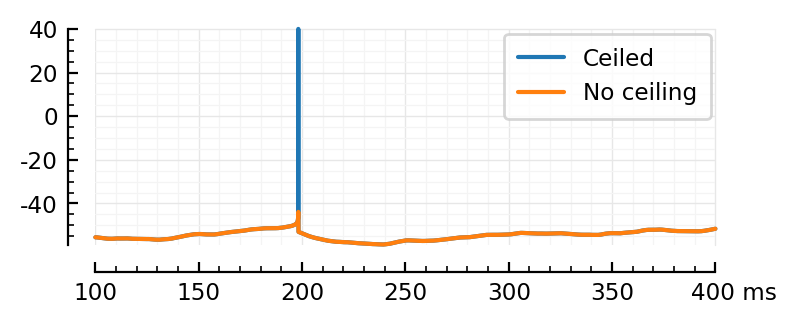

In [8]:
fig, ax = plt.subplots(figsize=(4, 1.4))
plotsig(V_ceil / mV,    [100, 400], ms, label="Ceiled")
plotsig(V_no_ceil / mV, [100, 400], ms, label="No ceiling")
legend(ax, reverse=false);

## Clip

And now for the clipping, we do it data driven (i.e. no spike detection), just a percentile.

In [9]:
include("lib/df.jl")

using DataFrames … ✔ (0.9 s)


In [10]:
set_print_precision(4)
ENV["DATAFRAMES_ROWS"] = 12;

In [11]:
ps = [0, 0.1, 1, 5, 10, 50, 90, 95, 99, 99.9, 99.95, 99.99, 100]
qs = percentile(V_ceil, ps)
df = DataFrame("p" => ps, "V (mV)" => qs/mV)
showsimple(df)

 p       V (mV) 
────────────────
   0     -65
   0.1   -58.75
   1     -58.07
   5     -57.37
  10     -56.91
  50     -53.98
  90     -51.6
  95     -51.06
  99     -49.79
  99.9   -46.77
  99.95  -44.24
  99.99   40
 100      40

In [12]:
df_ = permutedims(df, "p", strict=false)
showsimple(df_, allcols=true)

 p       0.0  0.1     1.0     5.0     10.0    50.0    90.0   95.0    99.0    99.9    99.95   99.99  100.0 
──────────────────────────────────────────────────────────────────────────────────────────────────────────
 V (mV)  -65  -58.75  -58.07  -57.37  -56.91  -53.98  -51.6  -51.06  -49.79  -46.77  -44.24  40     40

Okay, lesgo for 99.

In [13]:
clip!(V, p = 99) = begin
    V_thr = percentile(V, p)
    to_clip = V .≥ V_thr
    V[to_clip] .= V_thr
    V
end

V_ceil_n_clip = clip!(copy(V_ceil));

In [14]:
Vs = [
    (V = V_no_ceil,     label = "No ceiling",       zorder = 2),
    (V = V_ceil,        label = "Ceiled spikes",    zorder = 1),
    (V = V_ceil_n_clip, label = "Ceiled & Clipped", zorder = 3),
];

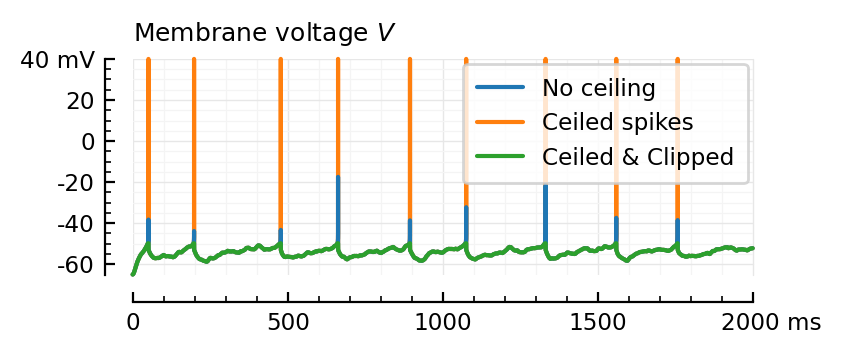

In [15]:
fig, ax = plt.subplots(figsize=(4, 1.4))
for (V, label, zorder) in Vs
    plotsig(V, [0, 2000], ms; label, zorder, yunit=:mV)
end
hylabel(ax, L"Membrane voltage $V$")
legend(ax);

## STAs

In [16]:
exc_input_1 = highest_firing(excitatory_inputs(sim))[1]

SpikeTrain(58522 spikes, 97.54 Hz, [0.004668, 0.01482, 0.04501, 0.04727, 0.05836, 0.07584, 0.0927, 0.1063, 0.1094, 0.1099  …  599.9, 600, 600, 600, 600, 600, 600, 600, 600, 600])

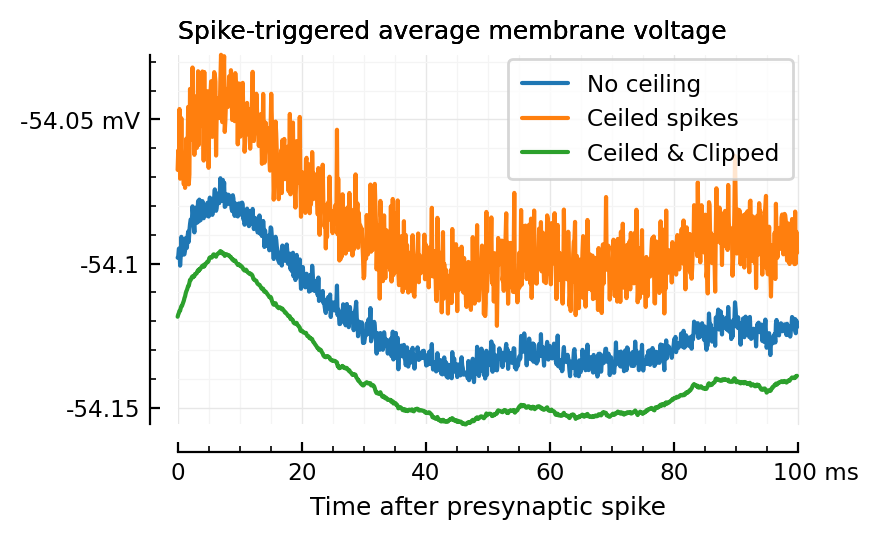

In [17]:
fig, ax = plt.subplots()
# set(ax, ylim=[-54.1601, -54.02])  # grr
for (V, label, zorder) in Vs
    STA = calc_STA(V, exc_input_1.times)
    plotSTA(STA; label, nbins_y=4)
end
plt.legend();

Interesting! They have diff base heights (very convenient for plotting on same ax, here).

Ok, it makes sense. They're averages: each sample dragged down or up.

## ROCs

In [18]:
trains_to_test = get_trains_to_test(sim);

In [19]:
ConnectionTests.set_STA_length(20ms);

In [20]:
function test_conns(V)
    test(train) = test_conn(STAHeight(), V, train.times)
    rows = []
    for (conntype, trains) in trains_to_test
        descr = string(conntype)
        @showprogress descr for train in trains
            t = test(train)
            fr = spikerate(train)
            push!(rows, (; conntype, fr, t))
        end
    end
    DataFrame(rows)
end;

In [21]:
MemDiskCache.set_dir("2023-09-13__Clippin_and_Ceilin")

"C:\\Users\\tfiers\\.julia\\MemDiskCache.jl\\2023-09-13__Clippin_and_Ceilin"

In [22]:
df_no_ceil     = @cached test_conns(V_no_ceil);      # 55.6 seconds

Loading [C:\Users\tfiers\.julia\MemDiskCache.jl\2023-09-13__Clippin_and_Ceilin\test_conns(V_no_ceil).jld2] … ✔ (2.6 s)


In [23]:
df_ceil        = @cached test_conns(V_ceil);         # 51.3 seconds

Loading [C:\Users\tfiers\.julia\MemDiskCache.jl\2023-09-13__Clippin_and_Ceilin\test_conns(V_ceil).jld2] … ✔


In [24]:
df_ceil_n_clip = @cached test_conns(V_ceil_n_clip);  # 51.8 seconds

Loading [C:\Users\tfiers\.julia\MemDiskCache.jl\2023-09-13__Clippin_and_Ceilin\test_conns(V_ceil_n_clip).jld2] … ✔


In [26]:
dfs = [df_no_ceil, df_ceil, df_ceil_n_clip];
sweeps = sweep_threshold.(dfs)
AUCs = calc_AUROCs.(sweeps);

In [27]:
labels = extract(:label, Vs);

In [28]:
df = DataFrame(AUCs)
insertcols!(df, 1, :V_type=>labels)
showsimple(df)

 V_type            AUC     AUCₑ    AUCᵢ   
──────────────────────────────────────────
 No ceiling        0.7485  0.6617  0.8354
 Ceiled spikes     0.5632  0.4909  0.6354
 Ceiled & Clipped  0.7874  0.6912  0.8836

Distilling from [mpl docs' Examples: Grouped bar chart with labels](https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html):

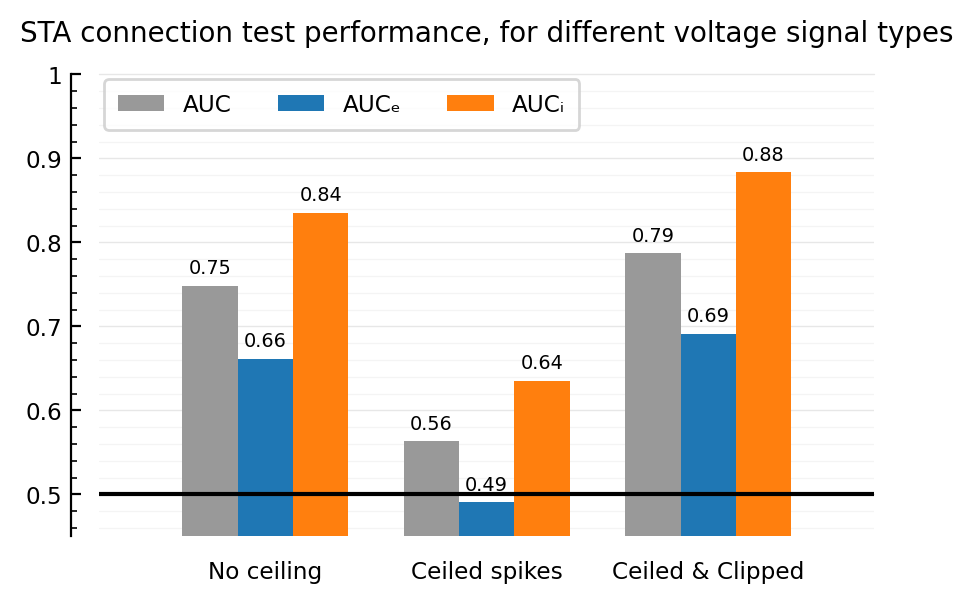

In [62]:
function grouped_barplot(df; cols, group_labels, ax=nothing, bar_label_fmt="%.2g", colors=nothing, kw...)
    N_groups = length(group_labels)
    N_bars_per_group = length(cols)
    if isnothing(ax)
        fig, ax = plt.subplots()
    end
    if isnothing(colors)
        colors = mplcolors[1:N_bars_per_group]
    end
    x = 0:(N_groups - 1)
    width = 1/(N_bars_per_group + 1)
    for (i, (colname, color)) in enumerate(zip(cols, colors))
        values = df[!, colname]
        offset = (i-1) * width
        bars = ax.bar(x .+ offset, values, width, label=colname, color=toRGBAtuple(color))
        ax.bar_label(bars, padding = 3, fmt=bar_label_fmt, fontsize="x-small")
    end
    set(ax, xtype=:categorical)
    ax.set_xticks(x .+ width, group_labels)
    return ax
end

fig, ax = plt.subplots(figsize=(5, 3))
ax.axhline(0.5, color="black")
colors = [color_both, color_exc, color_inh]
ax = grouped_barplot(df, cols=["AUC", "AUCₑ", "AUCᵢ"], group_labels=df.V_type; ax, colors);
legend(ax, ncols=3, loc="upper left")
set(ax, ylim=[0.45, 1], xtype=:keep, title="""
    STA connection test performance, for different voltage signal types""");

## Threshold-plot

Visualize what ROC is.

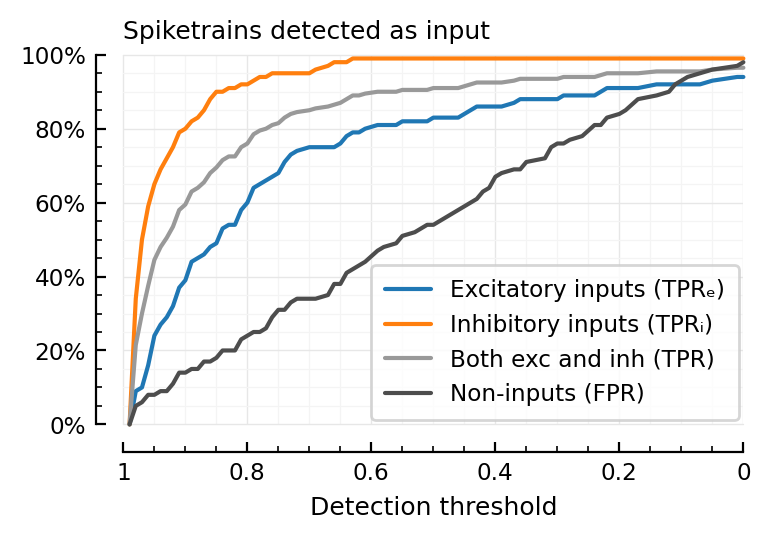

In [105]:
sweep = sweep_threshold(df_ceil_n_clip)

fig, ax = plt.subplots()
plot(sweep.threshold, sweep.TPRₑ, color=color_exc, label="Excitatory inputs (TPRₑ)")
plot(sweep.threshold, sweep.TPRᵢ, color=color_inh, label="Inhibitory inputs (TPRᵢ)")
plot(sweep.threshold, sweep.TPR, color=color_both, label="Both exc and inh (TPR)")
plot(sweep.threshold, sweep.FPR, color=color_unconn, label="Non-inputs (FPR)")
# plot(sweep.threshold, F1.(sweep), color=C2, label="F1")
# plot(sweep.threshold, PPV.(sweep), color=C3, label="Precision")
set(ax, ytype=:fraction, hylabel="Spiketrains detected as input", xlabel="Detection threshold")
ax.invert_xaxis()
legend(ax);

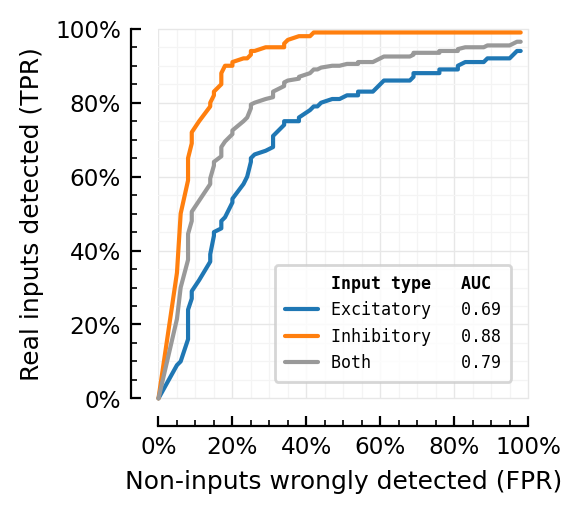

In [103]:
plotROC(sweep);

In [122]:
PPVs = PPV.(sweep);
F1s = F1.(sweep);

missing_to_nan(x) = coalesce.(x, NaN);

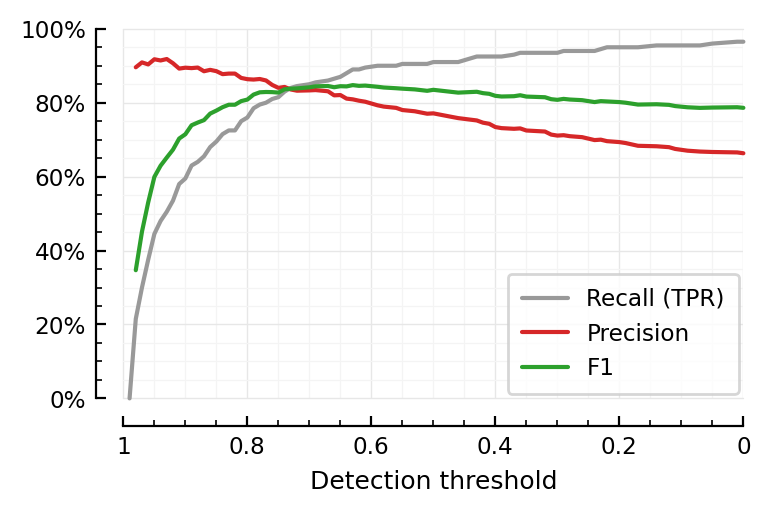

In [123]:
fig, ax = plt.subplots()

plot(sweep.threshold, sweep.TPR, color=color_both, label="Recall (TPR)")
plot(sweep.threshold, missing_to_nan(PPVs), color=C3, label="Precision")
plot(sweep.threshold, missing_to_nan(F1s), color=C2, label="F1")
set(ax, ytype=:fraction, xlabel="Detection threshold")
ax.invert_xaxis()
legend(ax);

Where is F1 maximal?

In [126]:
i = argmax(skipmissing(F1s))

35

In [127]:
sweep[i].threshold

0.63

In [128]:
F1s[i]

0.8476